# Task1 
Train a Convolutional Neural Network on the Flowers102 dataset

My solution uses a personal library that developed (outside of the scope of the assignment). It implements and tests several common / frequent routines and sub-tasks including ensuring reproducibility, transfer learning, static analysis of a model's output and input dimensions..

I will be using some code of [this library](https://github.com/ayhem18/pytorch_modular) in this assignment 

In [2]:
! git clone https://github.com/ayhem18/pytorch_modular.git

fatal: destination path 'pytorch_modular' already exists and is not an empty directory.


In [3]:
# Remove some extra inner projects and leave only the library source code 

! rm -r ./pytorch_modular/.vscode/
! rm -r ./pytorch_modular/image_classification/
! rm -r ./pytorch_modular/object_localization/
! rm -r ./pytorch_modular/simClr/
! rm -r ./pytorch_modular/UnsupervisedDomainAdaptation/

rm: cannot remove './pytorch_modular/.vscode/': No such file or directory
rm: cannot remove './pytorch_modular/image_classification/': No such file or directory
rm: cannot remove './pytorch_modular/object_localization/': No such file or directory
rm: cannot remove './pytorch_modular/simClr/': No such file or directory
rm: cannot remove './pytorch_modular/UnsupervisedDomainAdaptation/': No such file or directory


In [4]:
# install the source code as a pip package
! python -m pip install -e ./pytorch_modular/src

Obtaining file:///home/ayhem18/DEV/Towards_Data_Science/tba/p4/code/pytorch_modular/src
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mypt
    Found existing installation: mypt 0.1.0
    Uninstalling mypt-0.1.0:
      Successfully uninstalled mypt-0.1.0
  DEPRECATION: Legacy editable install of mypt==0.1.0 from file:///home/ayhem18/DEV/Towards_Data_Science/tba/p4/code/pytorch_modular/src (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for mypt


In [ ]:
import os, torch
from common import load_data
SCRIPT_DIR = os.getcwd()
DATA_FOLDER = os.path.join(SCRIPT_DIR, 'data')
os.makedirs(DATA_FOLDER, exist_ok=True)

In [7]:
import torchvision.transforms as tr
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.transforms as tr
from torch.optim.sgd import SGD
from common import train_model, load_data



## Baseline

The model definition as well as the code for training can be found on the `baseline.py` script

Each model was trained in their corresponding scripts because scripts are faster to run and can be run on `tmux` server (disconnecting from the terminal and leaving them run in the background)

Screenshots of the TensorBoard logs are provided

In [ ]:
from baseline import BaselineCnn

bcnn = BaselineCnn()

# add mini-max scaling 
train_ds, val_ds, test_ds = load_data(parent_dir=DATA_FOLDER, augs=[tr.ToTensor(), # convert to a tensor 
                                                                    tr.Resize(size=(200, 200)), # resize to the same input shape
                                                                    tr.Lambda(lambda x: x / 255.0) # min
                                                                    ]) 

optimizer = SGD(params=bcnn.parameters(), lr=0.001,)

train_model(
        train_ds, 
        val_ds, 
        train_batch_size=256, 
        test_batch_size=512,
        net = bcnn, 
        model_name="baseline_cnn",
        optimizer=optimizer,
        learning_scheduler=None, # no learning rate scheduling
        num_epochs=10, 
        num_warmup_epochs=None, # no warmup epochs 
        save_model_path=os.path.join(DATA_FOLDER, 'models', 'cnn'),
        )

In [ ]:
# load the model and compute the accuracy on the 'test dataset'

## Improved

The baseline model is extremely simple and hence extremely low capacity. Such an observation is confirmed by the high training loss and low training accuracy (1\%). A main principle in Machine Learning is to first have a model that fits the training data before moving to evaluation on unseen data. Bearing this in mind, I opt for techniques to improve the model performance on the $train$ dataset as a good performance on the train dataset is a pre-requisite for good performance on unsee data.

* Increasing the model capacity by adding non-linear activation layers and adding more Convolutional Layers (the new models ends up with 1024 channels)
* Batch normalization to tackle covariate bias
* Warmup epochs + learning rate scheduling

In [ ]:
from improved import ImprovedCnn
cnn = ImprovedCnn()

# add mini-max scaling 
train_ds, val_ds, test_ds = load_data(parent_dir=DATA_FOLDER, augs=[tr.ToTensor(), # convert to a tensor 
                                                                tr.Resize(size=(200, 200)), # resize to the same input shape
                                                                tr.Lambda(lambda x: x / 255.0) # min
                                                                ]) 


optimizer = SGD(params=cnn.parameters(), lr=0.001,)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.9)

train_model(
        train_ds, 
        val_ds, 
        train_batch_size=32, 
        test_batch_size=32,
        model_name="cnn",
        net = cnn, 
        optimizer=optimizer,
        learning_scheduler=lr_scheduler,
        num_epochs=4, 
        num_warmup_epochs=2, 
        save_model_path=os.path.join(DATA_FOLDER, 'models', 'cnn'),
        )

## Resnet50-Based

In [ ]:
from transfer import ResnetClassifier

# add mini-max scaling 
train_ds, val_ds, test_ds = load_data(parent_dir=DATA_FOLDER, augs=[tr.ToTensor(), # convert to a tensor 
                                                                tr.Resize(size=(200, 200)), # resize to the same input shape
                                                                tr.Lambda(lambda x: x / 255.0) # min
                                                                ]) 

resnet = ResnetClassifier(input_shape=(3, 200, 200), 
                            num_classes=102, 
                            num_fc_layers=3, # add 3 fully connected layers 
                            dropout=0.1, # apply 0.1 dropout at each fc layer
                            fe_num_blocks=-1, # use the entire resnet model (the class has the ability to choose parts of the model)
                            freeze=4, # freeze 4 out 5 residual blocks
                            architecture=50 # Resnet50 should do the trick
                            )


optimizer = SGD(params=resnet.parameters(), lr=0.01,)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.9)

train_model(
        train_ds, 
        val_ds, 
        train_batch_size=8, 
        test_batch_size=8,
        model_name="resnet",
        net = resnet, 
        optimizer=optimizer,
        learning_scheduler=lr_scheduler,
        num_epochs=4, 
        num_warmup_epochs=2, 
        save_model_path=os.path.join(DATA_FOLDER, 'models', 'resnet'),
        )

  0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

# Task 2

* choose the Resnet50-based model to extract feature
* use the elbow method to select the appropriate number of clusters

In [20]:
# load the data
_, val_ds, _ = load_data(parent_dir=DATA_FOLDER, augs=[tr.ToTensor(), # convert to a tensor 
                                                                tr.Resize(size=(200, 200)), # resize to the same input shape
                                                                tr.Lambda(lambda x: x / 255.0) # min
                                                                ]) 

# load the model
from mypt.code_utilities.pytorch_utilities import get_default_device
from mypt.data.dataloaders.standard_dataloaders import initialize_val_dataloader
resnet_ckpnt = os.path.join(DATA_FOLDER, 'models', 'resnet', 'resnet.pt')
resnet.load_state_dict(torch.load(resnet_ckpnt))
device = get_default_device()
resnet.eval()
resnet = resnet.to(device)

/tmp/ipykernel_6286/833501255.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(resnet_ckpnt))


In [ ]:
# extract the features as follows: 
import numpy as np

dataloder = initialize_val_dataloader(val_ds, seed=0, batch_size=256, num_workers=0, warning=False)

features = []

for batch in dataloder:
    x, _ = batch
    batch_features = resnet.flatten_layer.forward(resnet.fe.forward(x.to(device))).detach().cpu().tolist()
    features.extend(batch_features)

# convert features to a numpy array
features = np.asarray(features)

iterating through different numbers of clusters: 100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


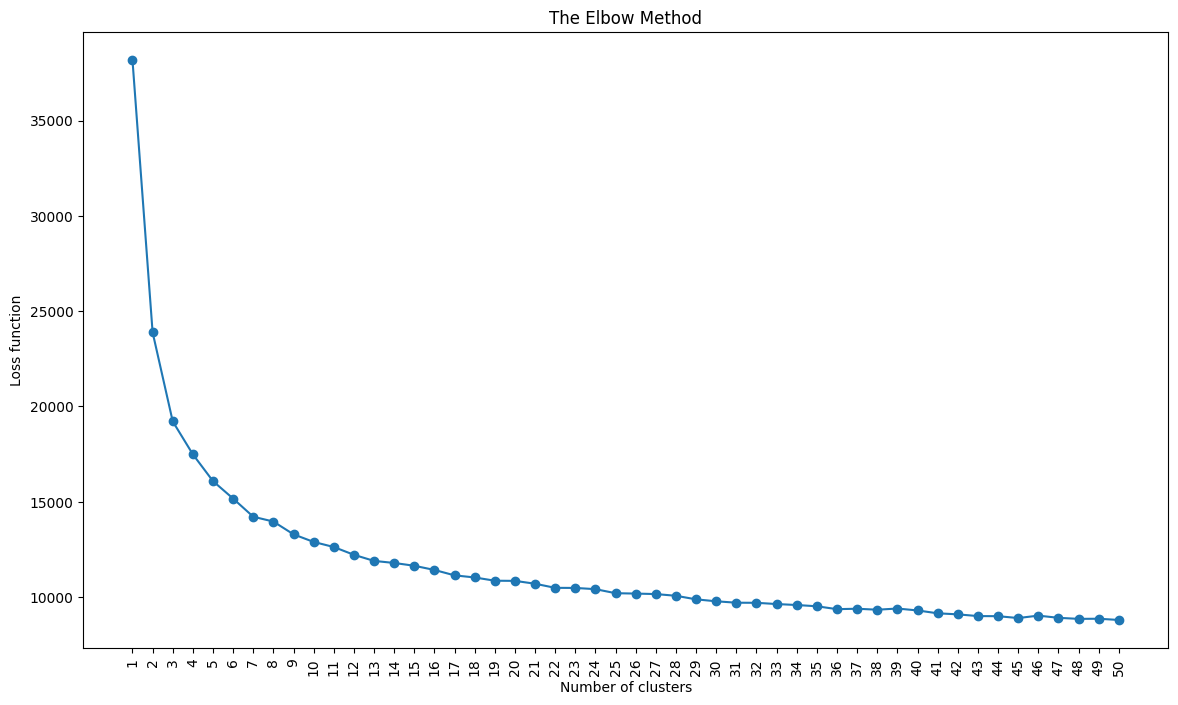

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
# Let's assume that features already contains extracted image features

losses = []
for i in tqdm(range(1, 51), desc="iterating through different numbers of clusters"):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    losses.append(kmeans.inertia_)


plt.figure(figsize=(14, 8))
plt.plot(range(1, 51), losses, marker='o')
plt.title("The Elbow Method: Kmeans performance with different number of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Loss function')
plt.xticks(range(1, 51), rotation=90)
plt.show()

In [ ]:
NUM_CLUSTERS = 8 # chosen graphically 

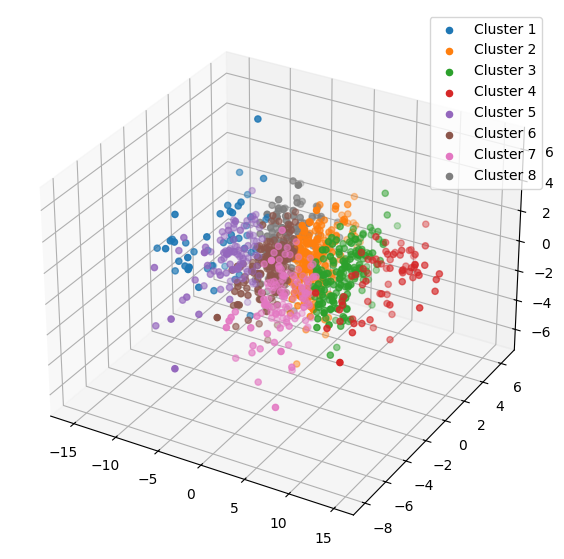

In [ ]:
from sklearn.decomposition import PCA

features = np.array(features)

kmeans = KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(features)

cluster_labels = kmeans.labels_

pca = PCA(n_components=3)  
features_pca = pca.fit_transform(features)

# Visualizing clusters
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection="3d")
for i in range(NUM_CLUSTERS):
    ax.scatter(features_pca[cluster_labels == i, 0], features_pca[cluster_labels == i, 1], 
               features_pca[cluster_labels == i, 2], label='Cluster '+str(i+1))

plt.legend()
plt.show()